In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import xgboost as xgb
from subprocess import check_output
%matplotlib inline
from sklearn import datasets, svm, metrics
from keras.applications.resnet50 import ResNet50
np.random.seed(0)

Using TensorFlow backend.


In [2]:
import data_loader
train_files, train_labels, valid_files, valid_labels, test_files, test_labels, label_dict = data_loader.load_dataset('facial_expressions/images', 'facial_expressions/data/legend.csv', valid_rate=0.1)

In [3]:
def image_to_feature_vector(image, size=(64, 64)):
	return cv2.resize(image, size).flatten()

In [4]:
tr_images = []

for t,im_path in enumerate(train_files):
  img = cv2.imread(im_path, 0)
  img2 = image_to_feature_vector(img)
  tr_images.append(img2)

tr_images = np.asarray(tr_images)

In [5]:
ts_images = []

for t,im_path in enumerate(test_files):
  img = cv2.imread(im_path, 0)
  img2 = image_to_feature_vector(img)
  ts_images.append(img2)

ts_images = np.asarray(ts_images)

In [11]:
va_images = []

for t,im_path in enumerate(valid_files):
  img = cv2.imread(im_path, 0)
  img2 = image_to_feature_vector(img)
  va_images.append(img2)

va_images = np.asarray(va_images)

## XGBoost

In [6]:
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

from xgboost import plot_importance
from matplotlib import pyplot
import pprint
%matplotlib inline

In [7]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])


In [8]:
pipeline.fit(tr_images, train_labels)


C:\Users\Nilesh Gandhi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Nilesh Gandhi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missin...
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))])

In [12]:
VaPredxgb = pipeline.predict(va_images)

C:\Users\Nilesh Gandhi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [13]:
VaAccXGB = accuracy_score(valid_labels, VaPredxgb)

print("Validation XGB Accuracy: %.2f%%" % (VaAccXGB * 100.0))

Validation XGB Accuracy: 77.16%


In [9]:
y_predxgb = pipeline.predict(ts_images)

C:\Users\Nilesh Gandhi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
AccXGB = accuracy_score(test_labels, y_predxgb)

print("XGB Accuracy: %.2f%%" % (AccXGB * 100.0))

XGB Accuracy: 76.63%


## SVM using SVD representation of images

In [24]:
from numpy.linalg import svd
X0 = []
meanX = np.mean(tr_images, axis=0)
# print(meanX.shape)
for i in range(len(tr_images)):
    X0.append(tr_images[i] - meanX)
    
X0 = np.array(X0)

U,S,V = svd(X0, False)
W = U.dot( np.diag(S) )
print("W Shape:", W.shape) 
print("V Shape:", V.shape)

W Shape: (11086, 4096)
V Shape: (4096, 4096)


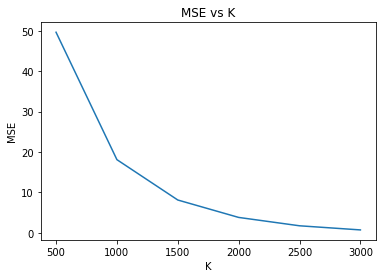

In [25]:
mse = []
K = [500, 1000, 1500, 2000, 2500, 3000]
for k in K:
    Xhat0 = W[:,:k].dot(V[:k,:])
    mse.append(np.mean((X0-Xhat0)**2))
    
plt.plot(K,mse)
plt.xlabel('K')
plt.ylabel('MSE')
plt.title('MSE vs K')
plt.show()

In [26]:
classifier = svm.SVC(gamma=0.001)
classifier.fit(Xhat0,train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
VaPredSVMSVD = classifier.predict(va_images)
ValAccSVMSVD = metrics.accuracy_score(valid_labels, VaPredSVMSVD)
print ("Validation SVM with SVD Accuracy: %.2f%%" % (ValAccSVMSVD * 100.0))

Validation SVM with SVD Accuracy: 50.33%


In [29]:
PredSVMSVD = classifier.predict(ts_images)
AccSVMSVD = metrics.accuracy_score(test_labels, PredSVMSVD)
print ("SVM with SVD Accuracy: %.2f%%" % (AccSVMSVD * 100.0))


SVM with SVD Accuracy: 49.78%
